# Embeddings - in future put it in external lib file

In [ ]:
import pandas as pd
from sms_norm import normalize_and_hash_series, dedupe_by_hash
from sms_embed import embed_dedup_dataframe, save_embeddings

# Load the ready-made synthetic data
df_raw = pd.read_csv("./artifacts_stage5/synthetic_one_originator.csv")  # <-- move the downloaded file there OR change path

# Normalize + dedupe
norm = normalize_and_hash_series(df_raw["raw_text"], seed=0)
norm.insert(0, "originator_id", df_raw["originator_id"])
norm.insert(1, "message_id", df_raw["message_id"])
dedup_df, _ = dedupe_by_hash(norm)

# Embed (offline MiniLM) and save CSV+NPY
LOCAL_MODEL = r"C:/models/all-MiniLM-L6-v2"  # local model folder
meta_df, X = embed_dedup_dataframe(
    dedup_df, text_col="normalized_text", id_col="template_hash_xx64",
    batch_size=64, normalize=True, model_name=LOCAL_MODEL
)
csv_path, npy_path = save_embeddings(meta_df, X, out_dir="./artifacts_stage5", prefix="week_synth")
print("Saved:", csv_path, npy_path)


Saved: ./artifacts_stage5\week_synth.csv ./artifacts_stage5\week_synth.npy


C:\Users\eliei\AppData\Roaming\Python\Python313\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\eliei\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\eliei\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Cluster counts: {np.int64(-1): np.int64(3), np.int64(0): np.int64(5), np.int64(1): np.int64(6), np.int64(2): np.int64(6), np.int64(3): np.int64(6), np.int64(4): np.int64(11)}


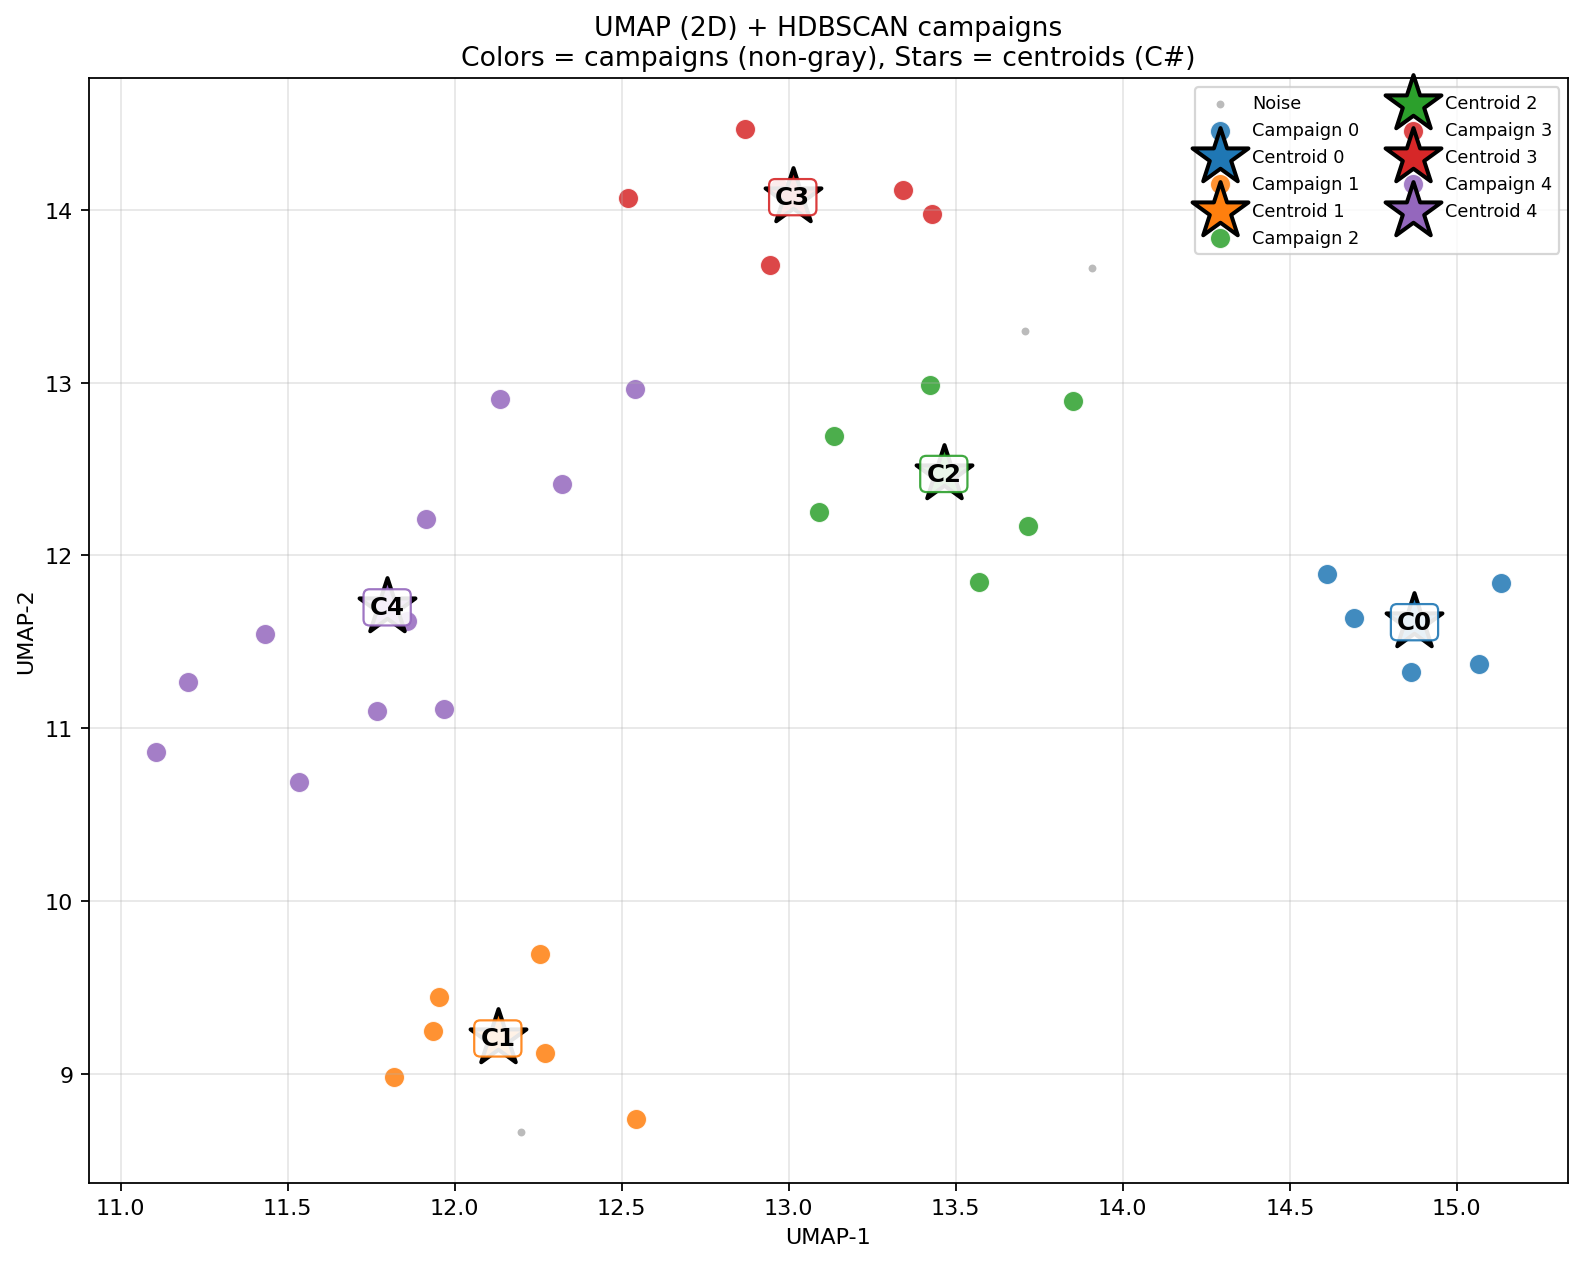

Saved:
 - campaigns.csv : ./artifacts_stage5\campaigns.csv
 - campaigns.npy : ./artifacts_stage5\campaigns.npy
 - points.csv    : ./artifacts_stage5\points.csv
 - plot          : ./artifacts_stage5\umap_hdbscan_campaigns.png


In [57]:
# UMAP + HDBSCAN + centroids + exemplars + plot (one originator) 

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap.umap_ as umap
import hdbscan
from plots import *
from sklearn.preprocessing import normalize

ART_DIR   = "./artifacts_stage5"
PREFIX    = "week_synth"  # from Stage 4 save_embeddings(...)
META_CSV  = os.path.join(ART_DIR, f"{PREFIX}.csv")
VEC_NPY   = os.path.join(ART_DIR, f"{PREFIX}.npy")

assert os.path.exists(META_CSV) and os.path.exists(VEC_NPY), "Run Stage 4 first to create CSV+NPY."

# Load meta + embeddings
meta = pd.read_csv(META_CSV)
X    = np.load(VEC_NPY)  # shape [N, D], unit-normalized

# UMAP to 2D (for visualization only)
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, metric="cosine", random_state=42)
X_2d = umap_model.fit_transform(X)  # [N, 2]

# HDBSCAN (auto number of clusters); -1 = noise

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=5,   # smaller -> more clusters; increase if too many
    min_samples=2,        # lower -> less noise
    metric= "euclidean"
)
labels = clusterer.fit_predict(X)
print("Cluster counts:", dict(zip(*np.unique(labels, return_counts=True))))

# Compute centroids in ORIGINAL space + exemplars per cluster
def compute_centroids_and_exemplars(X, labels, k=3):
    cluster_ids = sorted([c for c in set(labels) if c != -1])
    C = []
    rows = []
    for c in cluster_ids:
        idx = np.where(labels == c)[0]
        # centroid in original embedding space
        cvec = X[idx].mean(axis=0)
        cvec = cvec / (np.linalg.norm(cvec) + 1e-8)
        C.append(cvec)

        # exemplars: closest to centroid by cosine (dot with unit vectors)
        sims = X[idx] @ cvec
        ord_idx = idx[np.argsort(-sims)]
        ex_texts = [meta.iloc[i]["normalized_text"] for i in ord_idx[:k]]

        rows.append({
            "campaign_id": int(c),
            "size": int(len(idx)),
            "exemplar_1": ex_texts[0] if len(ex_texts) > 0 else "",
            "exemplar_2": ex_texts[1] if len(ex_texts) > 1 else "",
            "exemplar_3": ex_texts[2] if len(ex_texts) > 2 else "",
        })
    C = np.vstack(C) if len(C) else np.zeros((0, X.shape[1]), dtype=np.float32)
    return cluster_ids, C, pd.DataFrame(rows)

cluster_ids, C, campaigns_df = compute_centroids_and_exemplars(X, labels, k=3)

# Save artifacts
os.makedirs(ART_DIR, exist_ok=True)
campaigns_csv = os.path.join(ART_DIR, "campaigns.csv")
campaigns_npy = os.path.join(ART_DIR, "campaigns.npy")
points_csv    = os.path.join(ART_DIR, "points.csv")
plot_path     = os.path.join(ART_DIR, "umap_hdbscan_campaigns.png")

campaigns_df.to_csv(campaigns_csv, index=False, encoding="utf-8")
np.save(campaigns_npy, C.astype(np.float32))
pd.DataFrame({
    "template_hash_xx64": meta["template_hash_xx64"],
    "normalized_text": meta["normalized_text"],
    "umap_x": X_2d[:, 0], # type: ignore
    "umap_y": X_2d[:, 1], # type: ignore
    "label": labels
}).to_csv(points_csv, index=False, encoding="utf-8")

plot_campaigns(X_2d, labels, cluster_ids, plot_path)

print("Saved:")
print(" - campaigns.csv :", campaigns_csv)
print(" - campaigns.npy :", campaigns_npy)
print(" - points.csv    :", points_csv)
print(" - plot          :", plot_path)
